In [71]:
# import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel, Word2Vec
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import seaborn as sns
import stop_words
from scipy.stats import wasserstein_distance
from pyemd import emd
from scipy.spatial.distance import cosine
sns.set_style("darkgrid")

### Data Import

In [3]:
filepath = "data/fake.csv"
df = pd.read_csv(filepath, usecols = ['uuid','author','title','text','language','site_url','country'])
df = df[df.language == 'english']
df = df[df['text'].map(type) == str]
df['title'].fillna(value="", inplace=True)
df.dropna(axis=0, inplace=True, subset=['text'])
# shuffle the data
df = df.sample(frac=1.0)
df.reset_index(drop=True,inplace=True)
df.head()

,uuid,author,title,text,language,site_url,country
0,f5ec7f2d360edd9124583e0251903777341849fb,Arnaldo Rodgers,Donald Trump Tells Veterans He’s ‘Financially ...,Donald Trump Tells Veterans He’s ‘Financiall...,english,veteransnewsnow.com,US
1,a191d7fa744b81a57ad65cbe5ef482d9cd2b228b,DavidSwanson,Hurricane Donald and the Storms of Changing Cl...,"Posted on November 10, 2016 by DavidSwanson \n...",english,washingtonsblog.com,US
2,48ed7ee6e668ecfecfbe59144d8b4192d9bd7474,Activist Post,Police Caught Spying on Journalists to Uncover...,By Chris “Kikila” Perrin In what can only be d...,english,activistpost.com,US
3,1adcaa9c120f8c897114d161b7dd6f35e5d22d71,Charles Hugh Smith,“Nothing Good Can Come of This Election”–and T...,\nWe the citizens and voters have to stop bein...,english,thedailysheeple.com,US
4,af80ee8824610c200499795879eabd3fc54ea134,WashingtonsBlog,Live Report from Dakota Access Pipeline Protest,"Lincoln \nOctober 31, 2016 – STANDING ROCK SIO...",english,washingtonsblog.com,US


In [4]:
def initial_clean(text):
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stop_words.get_stop_words('english')
def remove_stop_words(text):
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    return stem_words(remove_stop_words(initial_clean(text)))

In [5]:
# clean text and title and create new column "tokenized"
#%time
t1 = time.time()
df['tokenized'] = df['text'].apply(apply_all) + df['title'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df), "articles:", (t2-t1)/60, "min")

('Time to clean and tokenize', 12357, 'articles:', 5.393310232957204, 'min')


In [6]:
# first get a list of all words
all_words = [word for item in df['tokenized'].tolist() for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

96283

In [7]:
# choose k and visually inspect the bottom 10 words of the top k
k = 50000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[(u'plasticin', 1),
 ('neverbut', 1),
 ('samadhi', 1),
 ('defencechristina', 1),
 (u'handtoey', 1),
 (u'respectabilityperhap', 1),
 ('naham', 1),
 ('trianglemr', 1),
 ('asno', 1),
 ('pedophila', 1)]

In [8]:
# choose k and visually inspect the bottom 10 words of the top k
k = 15000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[(u'peacetim', 13),
 (u'inconsol', 13),
 ('nikita', 13),
 (u'ith', 13),
 (u'megalith', 13),
 ('fatherson', 13),
 (u'bilingu', 13),
 ('postcivil', 13),
 (u'blot', 13),
 (u'psychoanalysi', 13)]

In [9]:
# define a function only to keep words in the top k words
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [10]:
df['tokenized'] = df['tokenized'].apply(keep_top_k_words)

In [11]:
# document length
doc_lengths = df['tokenized'].apply(lambda x: len(x)).tolist()

#df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "average document length", np.average(doc_lengths),
      "minimum document length", min(doc_lengths),
      "maximum document length", max(doc_lengths))

('length of list:', 12357, 'average document length', 349.3714493809177, 'minimum document length', 0, 'maximum document length', 11839)


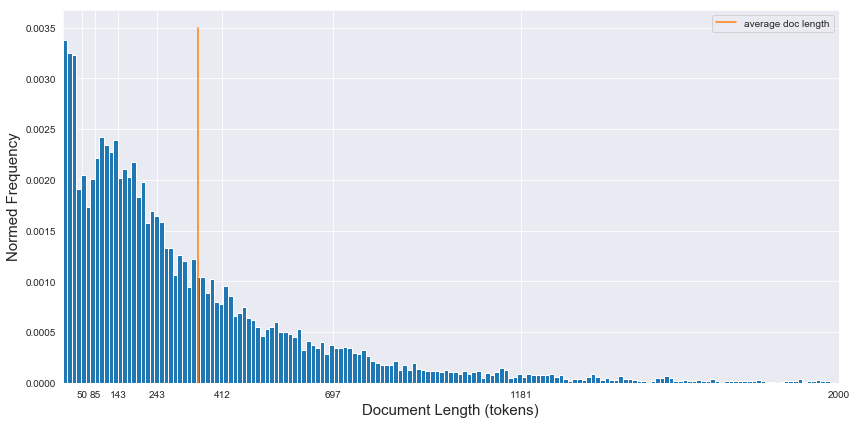

In [12]:
# plot a histogram of document length
num_bins = 1000
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, normed=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(2000),num=8, base=10.0))
plt.xlim(0,2000)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [13]:
# only keep articles with more than 30 tokens, otherwise too short
df = df[df['tokenized'].map(len) >= 40]
# make sure all tokenized items are lists
df = df[df['tokenized'].map(type) == list]
df.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df), "articles")

('After cleaning and excluding short aticles, the dataframe now has:', 10835, 'articles')


In [14]:
# create a mask of binary values
msk = np.random.rand(len(df)) < 0.999
msk

array([ True,  True,  True, ...,  True,  True,  True])

In [15]:
train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [16]:
print(len(df),len(train_df),len(test_df))

(10835, 10824, 11)


In [17]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 100
    chunksize = 300
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [18]:
dictionary,corpus,lda = train_lda(train_df)

/usr/local/lib/python2.7/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


('Time to train LDA model on ', 10835, 'articles: ', 1.4902590314547222, 'min')


In [19]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=10, num_words=20)

[(27,
  u'0.138*"mr" + 0.054*"agent" + 0.043*"foundat" + 0.036*"investig" + 0.030*"depart" + 0.028*"justic" + 0.023*"offici" + 0.023*"said" + 0.022*"fbi" + 0.016*"corrupt" + 0.015*"case" + 0.014*"offic" + 0.014*"probe" + 0.014*"doj" + 0.013*"deputi" + 0.012*"governor" + 0.011*"clinton" + 0.011*"peopl" + 0.011*"senior" + 0.011*"interview"'),
 (4,
  u'0.061*"energi" + 0.040*"moon" + 0.039*"light" + 0.036*"power" + 0.036*"sun" + 0.032*"planet" + 0.031*"space" + 0.024*"electr" + 0.024*"univers" + 0.023*"star" + 0.022*"solar" + 0.020*"earth" + 0.017*"signal" + 0.015*"system" + 0.015*"cosmic" + 0.015*"hole" + 0.014*"sky" + 0.014*"hayden" + 0.013*"grid" + 0.012*"wind"'),
 (18,
  u'0.030*"michel" + 0.024*"presidenti" + 0.020*"biden" + 0.020*"tim" + 0.020*"nation" + 0.017*"vice" + 0.017*"reportedli" + 0.016*"thursday" + 0.016*"onion" + 0.015*"kain" + 0.015*"nuclear" + 0.015*"day" + 0.013*"sourc" + 0.013*"joe" + 0.012*"report" + 0.012*"virginia" + 0.012*"america" + 0.012*"button" + 0.012*"night"

In [20]:
lda.show_topic(topicid=40, topn=20)

[(u'warn', 0.12986581),
 (u'post', 0.08443546),
 (u'note', 0.07766964),
 (u'new', 0.07231721),
 (u'announc', 0.06325758),
 (u'channel', 0.033478495),
 (u'subscrib', 0.030003393),
 (u'expect', 0.027299635),
 (u'line', 0.024634304),
 (u'address', 0.019614775),
 (u'comment', 0.019322276),
 (u'competitor', 0.017750554),
 (u'blog', 0.016977698),
 (u'show', 0.016456997),
 (u'via', 0.015632266),
 (u'pleas', 0.015158135),
 (u'notifi', 0.013987406),
 (u'struck', 0.012038441),
 (u'report', 0.011223259),
 (u'tweet', 0.010290799)]

In [96]:
random_article_index = np.random.randint(len(train_df))
bow = dictionary.doc2bow(train_df.iloc[random_article_index,7])
print(random_article_index)

8127


In [97]:
print(train_df.iloc[random_article_index,3])

Getty - Saul Loeb/AFP The Wildfire is an opinion platform and any opinions or information put forth by contributors are exclusive to them and do not represent the views of IJR. 
Sean Hannity took to the radio on Wednesday and was upfront about how he really feels about conservatives who refuse to vote for Trump. 
He kicked off his explosive rant by telling his listeners that he's “pissed,” and said: 
"In 13 freaking days, we are either going to make a decision to keep screwing the country up or we are going to try and fix it. That's what's at stake here. 
You want to get 95 million Americans back to work, you want to get the economy going, you want a president that has the courage to say 'radical Islam.' 
You want to not bring in refugees from countries that have laws that are the antithesis of our constitutional values. 
You want to control the borders, you want become energy independent, you want to eliminate Obamacare, you want to fix are dilapidated piece of crap educational system

In [98]:
# get the topic contributions for the document chosen at random above
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])

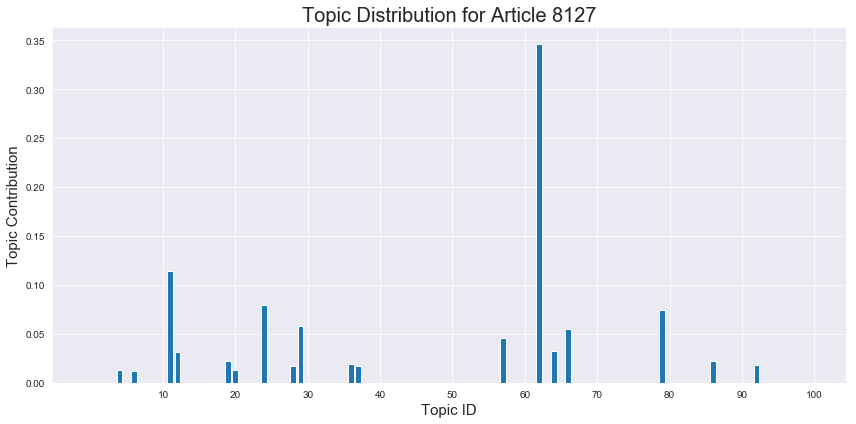

In [103]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.savefig("/Users/ankushbhatia/personal/seen.png")

In [25]:
# print the top 5 contributing topics and their words
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

(96, [(u'clinton', 0.15038684), (u'hillari', 0.06976869), (u'campaign', 0.036968004), (u'email', 0.031878695), (u'podesta', 0.021643208), (u'wikileak', 0.013405528), (u'presidenti', 0.010425213), (u'state', 0.008675588), (u'secretari', 0.008315119), (u'presid', 0.008275844)], '\n')
(3, [(u'us', 0.041608747), (u'gener', 0.020820163), (u'new', 0.014734904), (u'robert', 0.014168026), (u'john', 0.01237185), (u'former', 0.012253655), (u'polici', 0.012245725), (u'american', 0.012076125), (u'york', 0.011915496), (u'paul', 0.009620263)], '\n')
(21, [(u'climat', 0.017807623), (u'research', 0.017516196), (u'year', 0.013064853), (u'scientist', 0.012051121), (u'chang', 0.012041455), (u'scienc', 0.009962453), (u'studi', 0.0090091415), (u'sourc', 0.008153695), (u'publish', 0.007897473), (u'report', 0.0078111095)], '\n')
(59, [(u'fbi', 0.07040532), (u'investig', 0.054267384), (u'comey', 0.05063615), (u'elect', 0.026825422), (u'letter', 0.026576685), (u'director', 0.020009888), (u'jame', 0.016316893),

In [30]:
# select and article at random from test_df
random_article_index = np.random.randint(len(test_df))
print(random_article_index)
#random_article_index = 11

1


In [31]:
new_bow = dictionary.doc2bow(test_df.iloc[random_article_index,7])

In [64]:
print(test_df.iloc[random_article_index,3])

If Hillary wants to know what new information the FBI has, Sharyl Attkisson knows someone she could ask Posted at 4:34 pm on October 29, 2016 by Brett T. Share on Facebook Share on Twitter 
As Twitchy reported, Hillary Clinton held a brief press conference Friday to address news that the FBI had found — in the process of investigating Anthony Weiner’s alleged sexting of a 15-year-old girl — new emails that warranted further investigation into her own email scandal. 
Obviously not pleased by this latest development, Clinton called on the FBI to release whatever it had. Hillary Clinton: "We don't know the facts, which is why we're calling on the FBI to release all the information it has … let’s get it out." 
— New York Post (@nypost) October 28, 2016 
Despite that not being how FBI investigations work, Hillary’s call for the FBI to lay its cards on the table inspired Sharyl Attkisson of Full Measure News to make a simple suggestion: There's no mystery as to what's in the Huma Abedin emai

In [33]:
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])
#new_doc_distribution = doc_topic_dist[1271]

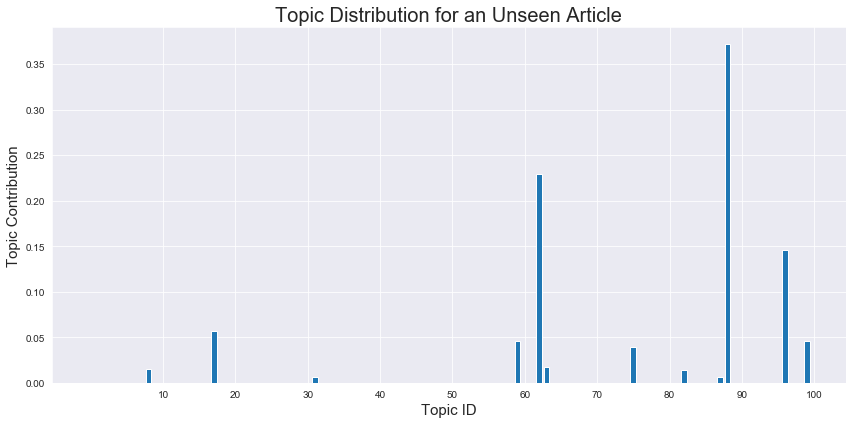

In [74]:
#Let's do the same visual analysis as before on this new unseen document

# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for an Unseen Article", fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.savefig("/Users/ankushbhatia/personal/unseen.png")

In [35]:
# print the top 8 contributing topics and their words
for i in new_doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

(88, [(u'email', 0.08811211), (u'fbi', 0.03897553), (u'investig', 0.023174088), (u'weiner', 0.022089763), (u'huma', 0.019996963), (u'abedin', 0.018895995), (u'server', 0.018070191), (u'clinton', 0.017246468), (u'inform', 0.016382504), (u'new', 0.014548894)], '\n')
(62, [(u'peopl', 0.021068325), (u'know', 0.019498106), (u'just', 0.019417021), (u'go', 0.018645955), (u'like', 0.017930241), (u'say', 0.016793415), (u'dont', 0.01635791), (u'think', 0.015671082), (u'get', 0.015182478), (u'want', 0.012638879)], '\n')
(96, [(u'clinton', 0.15038684), (u'hillari', 0.06976869), (u'campaign', 0.036968004), (u'email', 0.031878695), (u'podesta', 0.021643208), (u'wikileak', 0.013405528), (u'presidenti', 0.010425213), (u'state', 0.008675588), (u'secretari', 0.008315119), (u'presid', 0.008275844)], '\n')
(17, [(u'report', 0.03885602), (u'said', 0.03253058), (u'meet', 0.022208722), (u'told', 0.014504141), (u'call', 0.0134609435), (u'accord', 0.012909123), (u'also', 0.01175181), (u'presid', 0.010865378), 

In [36]:
# we need to use nested list comprehension here
# this may take 1-2 minutes...
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape

(10824, 100)

In [40]:
topics = lda.print_topics(num_topics=100, num_words=10)

In [41]:
M = []
for i in topics:
    tops = i[1].split('+')
    M.append([(float(j.split('*')[0]), j.split('*')[1].strip().strip('"')) for j in tops])

In [42]:
unique_words = set()
for i in M:
    for prob, word in i:
        unique_words.add(word)
unique_words = list(unique_words)

In [43]:
topic_matrix = np.zeros((len(M), len(unique_words)), dtype=np.float64)

In [44]:
for ind, i in enumerate(M):
    for prob, word in i:
        topic_matrix[ind, unique_words.index(word)] = prob

In [46]:
#Word2vec for given docs
w2v_model = Word2Vec(sentences=df.tokenized, workers=4, size=100)

In [47]:
word_sim_matrix = np.zeros((len(unique_words), len(unique_words)), dtype=np.float64)

In [128]:
%%time
metric_space = np.zeros((len(M), len(M)), dtype=np.float64)
for i in xrange(len(M)):
    for j in xrange(len(M)):
        metric_space[i, j] = emd(topic_matrix[i], topic_matrix[j], word_sim_matrix)

KeyboardInterrupt: 

In [48]:
for i in xrange(len(unique_words)):
    for j in xrange(len(unique_words)):
        word_sim_matrix[i, j] = cosine(w2v_model[unique_words[i]], w2v_model[unique_words[j]])     

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [198]:
metric_space.shape

(100, 100)

In [37]:
def jensen_shannon(query, matrix):
    p = query[None,:].T 
    q = matrix.T 
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

def emd_query(query, matrix):
    return np.array([emd(query, lst, metric_space) for lst in matrix])

In [114]:
def get_most_similar_documents(query,matrix,k=10):
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    #matrix = matrix.astype(np.float64)
    #query = query.astype(np.float64)
    #sims = emd_query(query, matrix)
    print sims.argsort()[:k]
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [116]:
# this is surprisingly fast
most_sim_ids = get_most_similar_documents(doc_distribution,doc_topic_dist)
most_sim_ids
print train_df.loc[1058, "text"]

[ 8127  1058 10345  5012  5951  7887  7015  2925  9838  2453]
October 27, 2016 @ 11:59 am 
I’m voting for him – but will be very quiet about it. 
I believe there Are many out there who are doing the same. Islam is not gay-friendly. It’s the leftist idiot who would believe that it is despite a mountain of evidence showing the truth about Islam. 
However – too many follow the company line. It is getting very demanding these days, and frankly very strange. But doesn’t the left always do that? Whatever problem there is within the right – at least there is enough room, and more than the case now with the left. Well – at least for this ‘cis’ white male. AndyT October 27, 2016 @ 11:39 am 
As a gay man I despair of my fellow gays. Here in the UK most have this “poor refugee” mentality. By time the penny finally drops it will be too late BareNakedIslam October 27, 2016 @ 12:34 pm 
Andy, while the majority still have that “poor refugee” mentality, I have seen a number of gay people commenting he

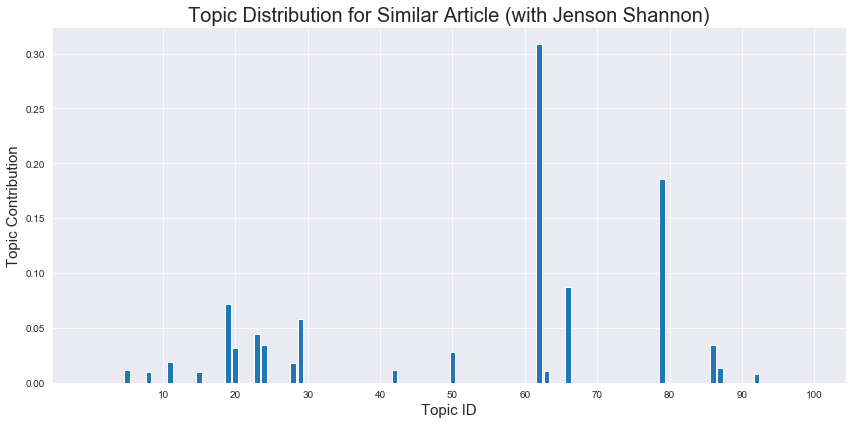

In [117]:
similar_bow = dictionary.doc2bow(train_df.iloc[1058,7])
similar_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=similar_bow)])
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(similar_distribution)), similar_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Similar Article (with Jenson Shannon)", fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
#plt.show()
plt.savefig("/Users/ankushbhatia/personal/seen_similar2.png")

In [105]:
most_similar_df = train_df[train_df.index.isin(most_sim_ids)]
for title in most_similar_df.text.tolist():
    print title
    print "#"*100

October 27, 2016 @ 11:59 am 
I’m voting for him – but will be very quiet about it. 
I believe there Are many out there who are doing the same. Islam is not gay-friendly. It’s the leftist idiot who would believe that it is despite a mountain of evidence showing the truth about Islam. 
However – too many follow the company line. It is getting very demanding these days, and frankly very strange. But doesn’t the left always do that? Whatever problem there is within the right – at least there is enough room, and more than the case now with the left. Well – at least for this ‘cis’ white male. AndyT October 27, 2016 @ 11:39 am 
As a gay man I despair of my fellow gays. Here in the UK most have this “poor refugee” mentality. By time the penny finally drops it will be too late BareNakedIslam October 27, 2016 @ 12:34 pm 
Andy, while the majority still have that “poor refugee” mentality, I have seen a number of gay people commenting here and/or emailing me who know the truth. They’re just afraid 

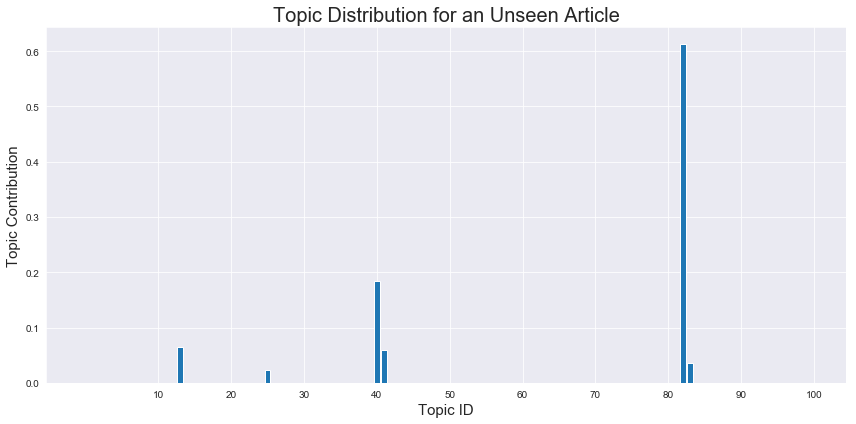

In [103]:
fig, ax = plt.subplots(figsize=(12,6));
patches = ax.bar(np.arange(len(new_doc_distribution)), doc_topic_dist[289])
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for an Unseen Article", fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

# DOC2VEC Training

In [118]:
from gensim.models import doc2vec
from collections import namedtuple

In [119]:
tagged_docs = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')

In [120]:
for ind, tokens in enumerate(train_df['tokenized'].tolist()):
    tags = [ind]
    tagged_docs.append(analyzedDocument(tokens, tags))

In [121]:
%%time
model = doc2vec.Doc2Vec(tagged_docs, size = 100, window = 300, workers = 4)

/usr/local/lib/python2.7/site-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


CPU times: user 10min 38s, sys: 2.2 s, total: 10min 41s
Wall time: 2min 53s


In [123]:
model.docvecs.most_similar(8127)

[(2500, 0.541205644607544),
 (6434, 0.5299692749977112),
 (9936, 0.5255742073059082),
 (3866, 0.513481855392456),
 (3828, 0.4958406686782837),
 (3083, 0.4937802255153656),
 (7310, 0.49006032943725586),
 (5220, 0.4874812662601471),
 (4183, 0.48325178027153015),
 (8481, 0.48033422231674194)]

In [127]:
print train_df.iloc[6434, 3]

0 comments 
Well, here’s a lesson for ya! Comedy and politics DON’T mix! So if you’re a comedian and you want to be successful- don’t bring politics into your act! Seriously, it just kills the mood, no one will be up to laughing after you insult them over who they are supporting for President, or whether or not they view abortion as murder. 
Who would find any humor in that? 
This should be common sense, but for Amy Schumer …twas not. Now she’s learning the hard way, what many of us were warning her about for a while now! 
According to AdWeek, Budweiser came in under expected profits in their third quarter, prompting the company to pull the Schumer ads ahead of schedule. The ads themselves were not at all doing well, and the last one received such negative attention on YouTube that it currently has more than 1,900 “thumbs down,” compared to only 300 “thumbs up.” 
Fox News reported that, at one time, the YouTube video had comments disabled, but that has since been changed. Many comments

In [73]:
df['new_check'] = df.uuid.copy()

In [126]:
train_df.index

RangeIndex(start=0, stop=10824, step=1)